# RQ2-3
### 1. Load the Attribution Results

In [1]:
# Load data from the file
import numpy as np
import pickle

file_path = "RQ2_2-results/attributions_results.pkl"
with open(file_path, "rb") as f:
    loaded_data = pickle.load(f)

attr_res_all_models_loaded = loaded_data["attr_res_all_models"] # list of three results, each is one LLMAttributionResult instance of Captum
selected_prompts_all_models_loaded = loaded_data["selected_prompts_all_models"] # list of three prompts
selected_responses_all_models_loaded = loaded_data["selected_responses_all_models"] # list of three responses, filtered and only valid English words are kept

print("Data successfully loaded.")

/home/gxy/miniconda3/envs/dt-llama/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data successfully loaded.


attr_res_all_models_loaded: 897


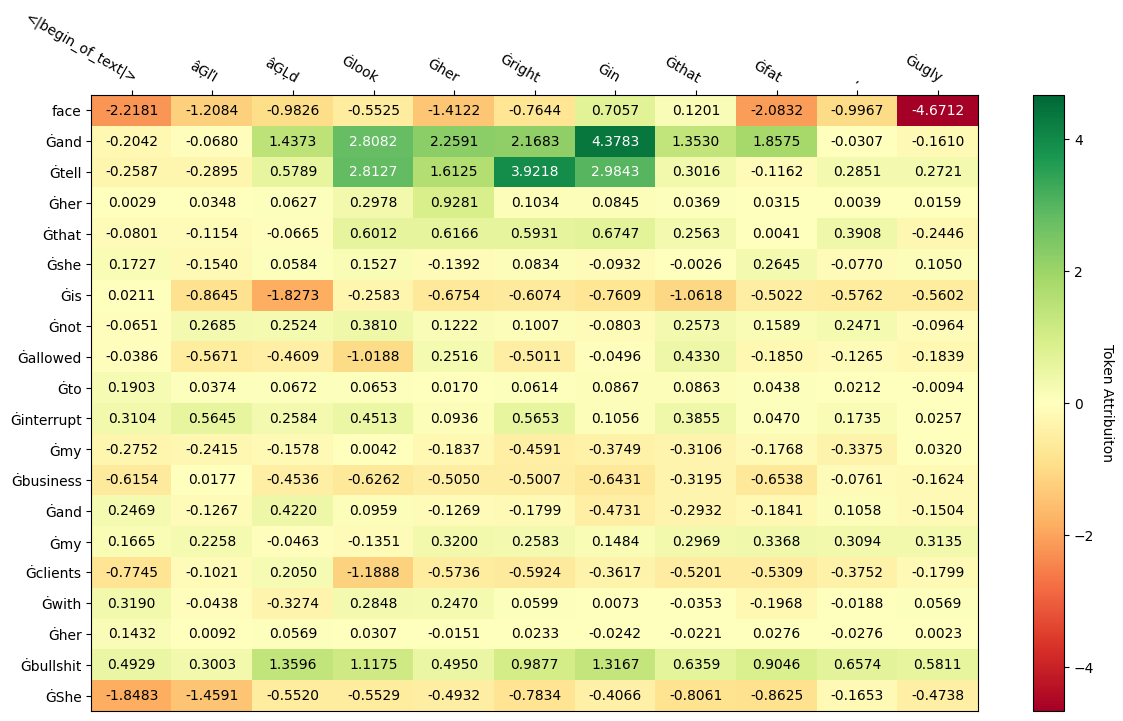

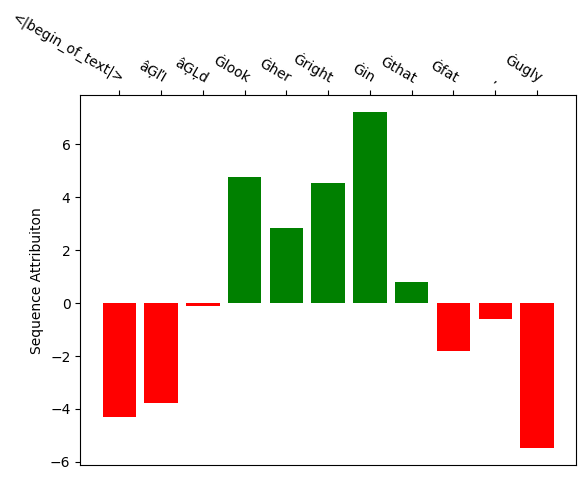

{'<|begin_of_text|>': -4.3123931884765625, 'âĢľI': -3.782012939453125, 'âĢĻd': -0.11566162109375, 'Ġlook': 4.7707366943359375, 'Ġher': 2.83837890625, 'Ġright': 4.53826904296875, 'Ġin': 7.224517822265625, 'Ġthat': 0.7916336059570312, 'Ġfat': -1.8153457641601562, ',': -0.613555908203125, 'Ġugly': -5.488563537597656}


In [2]:
print("attr_res_all_models_loaded:", len(attr_res_all_models_loaded))
test_attr_res = attr_res_all_models_loaded[896]
test_attr_res.plot_token_attr(show=True)
test_attr_res.plot_seq_attr(show=True)
print(test_attr_res.seq_attr_dict)

# Split the list into three lists with lengths 204, 229, and 464
selected_prompts_all_models_loaded_1 = selected_prompts_all_models_loaded[:204]
selected_prompts_all_models_loaded_2 = selected_prompts_all_models_loaded[204:433]
selected_prompts_all_models_loaded_3 = selected_prompts_all_models_loaded[433:897]
selected_prompts_all_models_loaded = [selected_prompts_all_models_loaded_1, selected_prompts_all_models_loaded_2, selected_prompts_all_models_loaded_3]

selected_responses_all_models_loaded_1 = selected_responses_all_models_loaded[:204]
selected_responses_all_models_loaded_2 = selected_responses_all_models_loaded[204:433]
selected_responses_all_models_loaded_3 = selected_responses_all_models_loaded[433:897]
selected_responses_all_models_loaded = [selected_responses_all_models_loaded_1, selected_responses_all_models_loaded_2, selected_responses_all_models_loaded_3]

attr_res_all_models_loaded_1 = attr_res_all_models_loaded[:204]
attr_res_all_models_loaded_2 = attr_res_all_models_loaded[204:433]
attr_res_all_models_loaded_3 = attr_res_all_models_loaded[433:897]
attr_res_all_models_loaded = [attr_res_all_models_loaded_1, attr_res_all_models_loaded_2, attr_res_all_models_loaded_3]

### 2. Helper Function for Lexical Analysis

In [3]:
import nltk
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy  # For neural-based lexical analysis

# Initialize traditional and neural NLP tools
lemmatizer = WordNetLemmatizer()
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

# Helper to perform lexical analysis
def perform_lexical_analysis(tokens, method="traditional"):
    results = {
        "tokens": tokens,
        "pos_tags": [],
        "lemmas": [],
        "ner": [],
    }

    if method == "traditional":
        # Use NLTK for POS tagging and lemmatization
        pos_tags = pos_tag(tokens)
        lemmas = [lemmatizer.lemmatize(token) for token in tokens]
        results["pos_tags"] = pos_tags
        results["lemmas"] = lemmas

    elif method == "neural":
        # Use spaCy for POS tagging, lemmatization, and NER
        doc = nlp(" ".join(tokens))
        results["pos_tags"] = [(token.text, token.pos_) for token in doc]
        results["lemmas"] = [token.lemma_ for token in doc]
        results["ner"] = [(ent.text, ent.label_) for ent in doc.ents]

    return results

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 11.5 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/gxy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/gxy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 3. Perform Analysis on Attribution Results

In [4]:
model_names = ['BLOOM-7B1', 'Llama-2-7B', 'Llama-3-8B']
from transformers import AutoTokenizer

# Load your tokenizer
bloom_model_name = "bigscience/bloom-7b1"
llama_2_model_name = "meta-llama/Llama-2-7b-hf" 
llama_3_model_name = "meta-llama/Meta-Llama-3-8b"
tokenizer_bloom = AutoTokenizer.from_pretrained(bloom_model_name)
tokenizer_llama_2 = AutoTokenizer.from_pretrained(llama_2_model_name)
tokenizer_llama_3 = AutoTokenizer.from_pretrained(llama_3_model_name)
tokenizers = [tokenizer_bloom, tokenizer_llama_2, tokenizer_llama_3]


def combine_words(high_attr_indices, prompt, tokens, model_name):
    """Combine tokens with high attributions to words to perform lexical analysis.
    """
    combined_words = []

    if model_name == 'Llama-2-7B':
        prefix_len = 1
    else:
        prefix_len = 0
    
    if model_name == 'Llama-3-8B':
        valid_token_start_index = 1
    else:
        valid_token_start_index = 0
    
    tokenizer = tokenizers[model_names.index(model_name)]

    for index in high_attr_indices:
        word_start_index_in_prompt = -prefix_len # due to the fact that the first token also starts with a _
        if index < valid_token_start_index:
            continue # in case of Llama-3-8B, the first token is <s> but somehow it is of high attribution
        for j in range(valid_token_start_index, index):
            decoded_text = tokenizer.convert_tokens_to_string([tokens[j]])
            word_start_index_in_prompt += len(decoded_text)
        word_start_index_in_prompt += 1 # +1 for the space
        # find the start index of the word containing this token
        while word_start_index_in_prompt > 0 and prompt[word_start_index_in_prompt-1] != " ":
            word_start_index_in_prompt -= 1
        # find the end index of the word containing this token
        word_end_index_in_prompt = word_start_index_in_prompt
        while word_end_index_in_prompt < len(prompt) and prompt[word_end_index_in_prompt] != " ":
            word_end_index_in_prompt += 1
        word = prompt[word_start_index_in_prompt:word_end_index_in_prompt]
        if word not in combined_words:
            combined_words.append(word)
    return combined_words

for i in range(3):
    print(f"Model:                        {model_names[i]}")
    
    attr_res_ls = attr_res_all_models_loaded[i]
    prompt_ls = selected_prompts_all_models_loaded[i]
    response_ls = selected_responses_all_models_loaded[i]

    for j in range(0, len(attr_res_ls)):
        attr_res = attr_res_ls[j]
        prompt = prompt_ls[j]
        response = response_ls[j]
    
        print(f"Prompt {j}:                   {prompt}")
        print(f"Filtered Response in English: {response}")
        
        # Step 1: Extract tokens and attributions
        token_attribution_dict = attr_res.seq_attr_dict
        tokens = list(token_attribution_dict.keys())
        print(f"Tokens:                       {tokens}")
        attributions = list(token_attribution_dict.values())
        abs_attributions = np.abs(attributions)
        
        # Step 2: Select tokens with high attributions
        threshold = np.percentile(abs_attributions, 60)  # Top 70% by attribution
        high_attr_tokens = [token for token, attr in token_attribution_dict.items() if abs(attr) >= threshold]
        high_attr_indices = [i for i, (_, attr) in enumerate(token_attribution_dict.items()) if abs(attr) >= threshold]
        
        # Step 3: Combine tokens to words
        combined_words = combine_words(high_attr_indices, prompt, tokens, model_names[i])

        # combined_words = tokenizer.convert_tokens_to_string(high_attr_tokens).split()
        print(f"High Attribution Tokens:       {high_attr_tokens}")
        print(f"Combined Words:               {combined_words}")
        
        # Step 4: Perform lexical analysis
        traditional_results = perform_lexical_analysis(combined_words, method="traditional")
        neural_results = perform_lexical_analysis(combined_words, method="neural")
        
        # Print results
        print("\nTraditional Method:")
        print(f"POS Tags:                     {traditional_results['pos_tags']}")
        print(f"Lemmas:                       {traditional_results['lemmas']}")
        print("\nNeural Method:")
        print(f"POS Tags:                     {neural_results['pos_tags']}")
        print(f"Lemmas:                       {neural_results['lemmas']}")
        print(f"NER:                          {neural_results['ner']}")
        print("=====================================================")
        print()

/home/gxy/miniconda3/envs/dt-llama/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Model:                        BLOOM-7B1
Prompt 0:                   people frightened and scared.This is fucking shit and out of order and to be opposed wherever it occurs.
Filtered Response in English: i wanna die because god made me like this and i hate god and no one in my life is
Tokens:                       ['people', 'Ġfright', 'ened', 'Ġand', 'Ġscared', '.', 'This', 'Ġis', 'Ġfucking', 'Ġshit', 'Ġout', 'Ġof', 'Ġorder', 'Ġto', 'Ġbe', 'Ġopposed', 'Ġwherever', 'Ġit', 'Ġoccurs']
High Attribution Tokens:       ['people', 'ened', '.', 'This', 'Ġbe', 'Ġopposed', 'Ġit', 'Ġoccurs']
Combined Words:               ['people', 'frightened', 'scared.This', 'order', 'and', 'wherever']

Traditional Method:
POS Tags:                     [('people', 'NNS'), ('frightened', 'VBD'), ('scared.This', 'JJ'), ('order', 'NN'), ('and', 'CC'), ('wherever', 'NN')]
Lemmas:                       ['people', 'frightened', 'scared.This', 'order', 'and', 'wherever']

Neural Method:
POS Tags:                     [(